In [6]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Global Parameters

In [7]:
# working dirs
datadir = "./"
outputdir = "./"

# parameters
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 15 #12
prefix = 'full_profile_'
suffix = '_roofline'
selectkeys = ['Kernel Name', 'Performance GFlop/s']

# markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

# styledict
styledict = {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}

# Plot Code

In [8]:
#plot roofs
def plot_roofs(fig, ax, xlim, ylim, styledict, scaling = 1.):
    #extract general settings
    fontsize_annotation = styledict["fontsize_annotation"] #10
    roof_color = styledict["roof_color"]
    
    #set up roofs
    #mem
    smemroofs = [14*1024, 2996.77, 789.56]
    smem_roof_name = ['L1', 'L2', 'HBM']
    #flops
    scomproofs_fp64 = [7068.86]
    #scomproofs_fp64 = [x*10**-3 for x in scomproofs_fp64]
    scomp_roof_name_fp64 = ['FP64 FMA']
    scomproofs_fp32 = [2.*x for x in scomproofs_fp64]
    scomp_roof_name_fp32 = ['FP32 FMA']
    scalingFactorForRoofs = scaling
    
    #resolution
    #nx = 10000
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    nx = 10*xmax
    
    #set limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    #plot roofs:
    dx = (xmax-xmin)/nx
    for idm, smem in enumerate(smemroofs):
        
        #fp64
        for idc, scomp in enumerate(scomproofs_fp64):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            #find elbow
            optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
            xelb = optimize["x"][0]
            yelb = min(smem*xelb, scomp)
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp64[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", weight='bold',
                            color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        #fp32
        for idc, scomp in enumerate(scomproofs_fp32):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp32[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", weight='bold',
                            color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        
        #plot mem
        #find intersection
        scomp = 1000.
        yis = ymin
        xis = minimize(fun = lambda x: np.abs(min([smem*x,scomp])-yis), x0=xmin, tol=1.e-10)["x"][0]
        #find elbow
        optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
        xelb = optimize["x"][0]
        yelb = min(smem*xelb, scomp)
        #angle in plot coord system
        ang = np.rad2deg( np.arctan2(yelb-yis, xelb-xis) )
        #angle in figure coord system
        pts = np.array((xelb, yelb)).reshape((1,2))
        trans_ang = ax.transData.transform_angles(np.array((ang,)), pts)[0]
        
        
        label = smem_roof_name[idm] + ': ' + '{0:.1f}'.format(float(smem)/scalingFactorForRoofs) + ' GB/s'
        ax.annotate(label, xy=(xelb, yelb), xytext=(3,-5), color=roof_color, \
                rotation=trans_ang, rotation_mode='anchor', \
                horizontalalignment='right', \
                verticalalignment='top', \
                weight='bold', \
                textcoords="offset points", \
                fontsize=fontsize_annotation)

In [9]:
#data dependent stuff
def roofline(label, df):
    
    #pick style:
    style = styledict
    
    #retrieve data
    labels = list(df['Kernel Name'])
    AI     = list(df["AI"])
    FLOPs  = list(df["Performance GFlop/s"])
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    
    xmin = -4
    xmax = 2
    ymin = 1e-2
    ymax = 14100.0*5.5 #max(FLOPs)*2./scalingFactorForRoofs

    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)
    
    for i in range(0,len(AI)):
        # top 5 kernels in red dot
        if i < 5:
            ax.plot(float(AI[i]),float(FLOPs[i]),c='r',marker=styles[0], ms=12)
        # medium kernels in yellow
        elif i < 20:
            ax.plot(float(AI[i]),float(FLOPs[i]),c='gold',marker=styles[1], ms=10)
        # small (negligible) kernels in green
        else:
            ax.plot(float(AI[i]),float(FLOPs[i]),c='green',marker=styles[2], ms=8)
    
    #save figure
    plt.tight_layout()
    plt.savefig(label+'.png')
    #plt.savefig(label+'.eps')

# Load Data

In [10]:
profiledf = pd.read_csv(os.path.join(datadir,"full_profile.csv"))
rawdf     = pd.read_csv(os.path.join(datadir,"metrics.csv"))

# Compute number of invocations
callsdf = rawdf.loc[rawdf["Metric Name"].str.contains("smsp__sass_thread_inst_executed_op_dfma_pred_on"), ["Kernel Name"] ].copy()
callsdf['Invocations'] = 1
callsdf = callsdf.groupby('Kernel Name').sum().reset_index()
# Merge with output DF
profiledf = profiledf.merge(callsdf, on='Kernel Name', how="inner")

# Add average run time
profiledf['Kernel Name'] = profiledf['Kernel Name'].str.split("(", 1).str[0]
profiledf['Average Runtime (us)'] = profiledf['CUDA Time'] / profiledf['Invocations'] * 1e6

# Print summary
tmpdf = profiledf[['Kernel Name', 'Invocations', 'Average Runtime (us)', 'CUDA Time', 'Performance GFlop/s', 'DRAM AI', 'L2 AI', 'L1 AI']].copy()
display(tmpdf)

,Kernel Name,Invocations,Average Runtime (us),CUDA Time,Performance GFlop/s,DRAM AI,L2 AI,L1 AI
0,kernel_find_ntuplets,100,185.466293,0.018547,0.000000,0.000000,0.000000,0.000000
1,void kernelBLFit<int=4>,200,73.287814,0.014658,19.524793,1.676884,1.192245,0.951080
2,gpuVertexFinder::vertexFinderOneKernel,100,120.522726,0.012052,0.953044,1.693960,0.305178,0.040561
3,gpuPixelDoublets::getDoubletsFromHisto,100,110.983141,0.011098,49.192655,0.254044,0.101006,0.050186
4,gpuClustering::findClus,100,96.892089,0.009689,0.000000,0.000000,0.000000,0.000000
5,kernel_connect,100,92.732481,0.009273,189.415546,0.659149,0.596238,0.275195
6,void kernelBLFit<int=3>,100,60.442692,0.006044,152.674457,2.371826,1.125450,0.978236
7,gpuPixelDoublets::fishbone,100,55.084764,0.005508,23.446294,0.076301,0.123679,0.072129
8,gpuPixelRecHits::getHits,100,52.371117,0.005237,42.837237,0.781094,0.506665,0.094442
9,void kernelBLFastFit<int=4>,200,12.319836,0.002464,8.769986,0.152236,0.252343,0.166976


# L1 Roofline:
* Top 5 kernels in <font color=red>red</font>, medium kernels (6 - 20) in <font color=gold>yellow</font>, > 20 in <font color=green>green</font>.

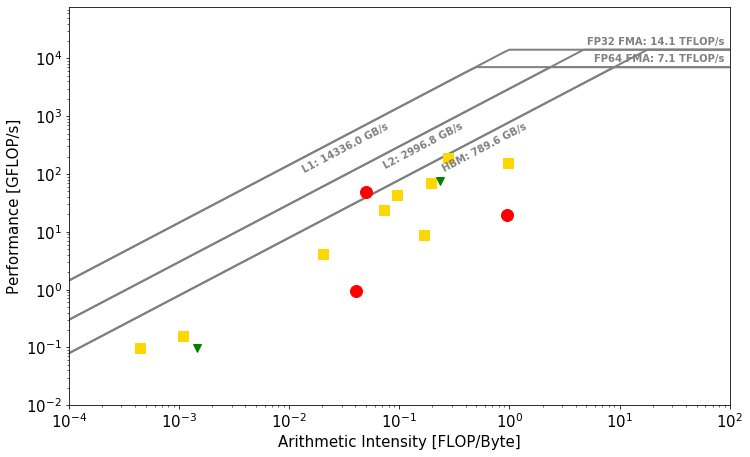

In [11]:
# Prepare L1 data
tmpdf = profiledf[selectkeys+["L1 AI"] ].copy().rename(columns={"L1 AI": "AI"})

# Plot
roofline(prefix+'l1'+suffix, tmpdf)

# L2 Roofline:
* Top 5 kernels in <font color=red>red</font>, medium kernels (6 - 20) in <font color=gold>yellow</font>, > 20 in <font color=green>green</font>.

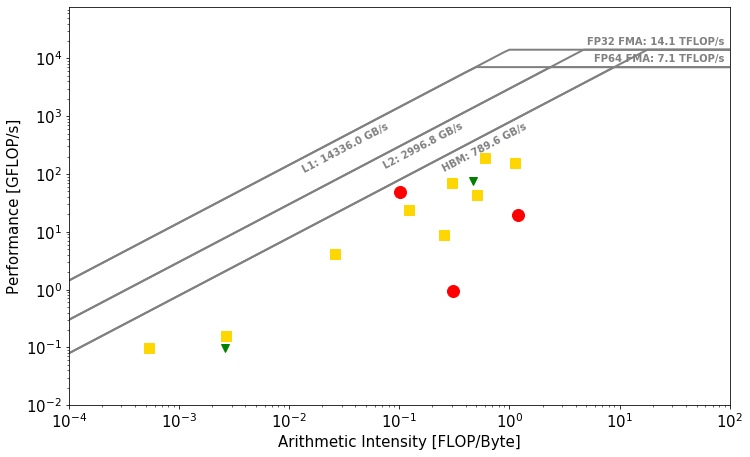

In [12]:
# Prepare L2 data
tmpdf = profiledf[selectkeys+["L2 AI"] ].copy().rename(columns={"L2 AI": "AI"})

# Plot
roofline(prefix+'l2'+suffix, tmpdf)

# DRAM Roofline:
* Top 5 kernels in <font color=red>red</font>, medium kernels (6 - 20) in <font color=gold>yellow</font>, > 20 in <font color=green>green</font>.

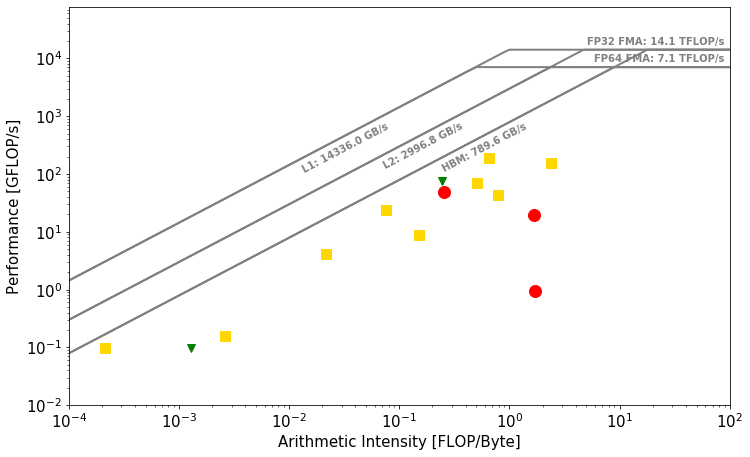

In [13]:
# Prepare DRAM data
tmpdf = profiledf[selectkeys+["DRAM AI"] ].copy().rename(columns={"DRAM AI": "AI"})

# Plot
roofline(prefix+'dram'+suffix, tmpdf)

# Hierarchical Roofline - Overview

In [14]:
#data dependent stuff
def hierarchical_roofline(label, flops, dram_ai, l2_ai, l1_ai):
    
    #pick style:
    style = styledict
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    
    xmin = -3
    xmax = 1.5
    ymin = 1e0
    ymax = 14100.0*5.5 #max(FLOPs)*2./scalingFactorForRoofs

    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)

    ax.plot(l1_ai,flops,c=colors[0],marker=styles[0], ms=markersize)
    ax.plot(l2_ai,flops,c=colors[1],marker=styles[0], ms=markersize)
    ax.plot(dram_ai,flops,c=colors[2],marker=styles[0], ms=markersize)

    #legend:
    patch_handles = []
    patch_handles.append(mpatches.Patch(color=colors[0],label = 'L1'))
    patch_handles.append(mpatches.Patch(color=colors[1],label = 'L2'))
    patch_handles.append(mpatches.Patch(color=colors[2],label = 'HBM'))
    leg2 = plt.legend(handles = patch_handles,loc='upper left', scatterpoints = 1, frameon=style["frameon"])
    
    #save figure
    plt.tight_layout()
    plt.savefig(label+'.png')
    #plt.savefig(label+'.eps')

GFLOPs/s: 35.0897
L1 AI:    0.1046
L2 AI:    0.1756
DRAM AI:  0.1945



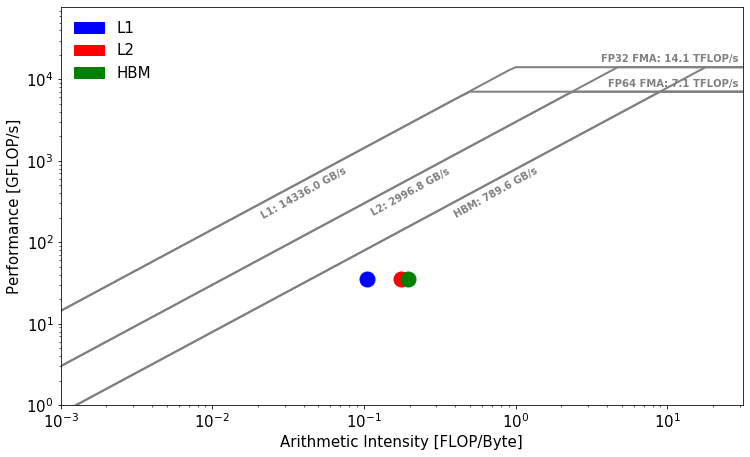

In [15]:
# Get combined data
total_flop = profiledf['FLOPs'].sum()
total_time = profiledf['CUDA Time'].sum()
total_dram = profiledf['DRAM Bytes'].sum()
total_l2   = profiledf['L2 Bytes'].sum()
total_l1   = profiledf['L1 Bytes'].sum()

# Compute final Perf & AI
flops   = total_flop / total_time / 1e9
dram_ai = total_flop / total_dram
l2_ai   = total_flop / total_l2
l1_ai   = total_flop / total_l1

print("GFLOPs/s: {:.4f}".format(flops))
print("L1 AI:    {:.4f}".format(l1_ai))
print("L2 AI:    {:.4f}".format(l2_ai))
print("DRAM AI:  {:.4f}\n".format(dram_ai))

# Plot Hierarchical Roofline
hierarchical_roofline('hierarchical_roofline_overview', flops, dram_ai, l2_ai, l1_ai )